In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [3]:
file_path = '/content/JinsangAffectionTrimmed.mp3'
x, sr = librosa.load(file_path)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050


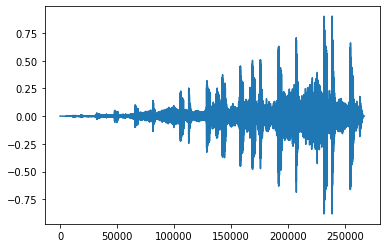

In [4]:
print(sr)
plt.plot(np.arange(len(x)), x)

In [5]:
onset_frames = librosa.onset.onset_detect(x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
print(onset_frames)
len(x)

[ 37  95  99 160 221 239 253 279 283 301 310 315 331 344 362 376 393 406
 424 438 454 467 485 499 515]


267264

In [6]:
onset_frames = librosa.onset.onset_detect(x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
onset_times = librosa.frames_to_time(onset_frames)
# remove extension, .mp3, .wav etc.
save_audio_txt = False#@param {type:"boolean"}

if save_audio_txt:
  file_name_no_extension, _ = os.path.splitext(file_path)
  file_name = f'working_dir/JinsangAffection'
  output_name = file_name_no_extension + '.beatmap.txt'
  with open(output_name, 'wt') as f:
      f.write('\n'.join(['%.4f' % onset_time for onset_time in onset_times]))

In [7]:
#@markdown Audio compoenent. Step 1: gets array that has time stamps of beats, and magnitudes. Create array whhere index is 
fps = 12 #frames per second
sec_total = 12 # total seconds of audio

t_lin_step = 1 / fps # the amount time represented by index
total_lin_step = sec_total * fps 
t_lin = np.linspace(0, sec_total, num=total_lin_step) # time steps of each frame and weight 

vals, bin_edgs = np.histogram(onset_times, bins=total_lin_step, range=(0,sec_total))

beat_factor_scale = 2.5
beat_factor_mask = ((vals+.5)/2)*beat_factor_scale
print(beat_factor_mask)

[0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 1.875 0.625
 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625
 0.625 0.625 1.875 1.875 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625
 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 1.875 0.625 0.625 0.625
 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625 0.625
 0.625 1.875 0.625 0.625 0.625 0.625 1.875 0.625 0.625 0.625 1.875 0.625
 0.625 0.625 0.625 0.625 0.625 1.875 1.875 0.625 0.625 0.625 0.625 1.875
 0.625 0.625 1.875 1.875 0.625 0.625 0.625 0.625 1.875 0.625 0.625 1.875
 0.625 0.625 0.625 0.625 1.875 0.625 0.625 0.625 1.875 0.625 0.625 0.625
 0.625 1.875 0.625 0.625 0.625 1.875 0.625 0.625 0.625 0.625 1.875 0.625
 0.625 0.625 1.875 0.625 0.625 0.625 1.875 0.625 0.625 0.625 1.875 0.625
 0.625 0.625 0.625 1.875 0.625 0.625 0.625 1.875 0.625 0.625 0.625 1.875]


In [8]:
beat_ind = np.argwhere(vals) # indices in terms of frames in vid of where beat occurs
beat_ind

frames_change_pre_beat = 0
frames_change_post_beat = 6 # there are the amount of buffer frames before and after a beat to let value linear change
#   If my beat is at 10.    9:(0), 10:(1), 22:(0). So between frames 10-22 they linearly scale. But look to change from linear to -exp 
post_beat_transition__value = 3
beat_transition_value = 12 
pre_beat_transition__value =0

key_frame_ind = beat_ind * np.ones((1, 3))

key_frame_ind[:, 0] -= (frames_change_pre_beat+1)
key_frame_ind[:, 2] += (frames_change_post_beat)

val_test = key_frame_ind.reshape(key_frame_ind.shape[0],3,1)
key_frame_value = []
post_beat = 99
for i in range(len(beat_ind)):
  #print()
  if post_beat < beat_ind[i]:
    post_tup = (post_beat,  post_beat_transition__value)
    key_frame_value.append(post_tup)
    #print(f"{i}  beat_ind[i]: {beat_ind[i]}, post {post_tup}")
  pre = (beat_ind[i] - frames_change_pre_beat - 1)[0]
  if len(key_frame_value) ==0 or len(key_frame_value)!=0 and key_frame_value[-1][0] != pre:
    #print(f"{i}  beat_ind[i]: {beat_ind[i]}, pre {pre, 0}")
    key_frame_value.append((pre, pre_beat_transition__value))
  beat = beat_ind[i][0]
  #print(f"{i}  beat_ind[i]: {beat_ind[i]}, beat {beat, beat_transition_value}")
  key_frame_value.append((beat,  beat_transition_value))
  post_beat = (beat_ind[i] + (frames_change_post_beat))[0]
  
print(key_frame_value)

string_list = []
for key_frame, val in key_frame_value:
  string = f"{key_frame}:({val}),"
  string_list.append(string)

key_frame_string = "".join(string_list)
key_frame_string

[(9, 0), (10, 12), (16, 3), (25, 0), (26, 12), (27, 12), (33, 3), (43, 0), (44, 12), (50, 3), (60, 0), (61, 12), (65, 0), (66, 12), (69, 0), (70, 12), (76, 3), (77, 12), (78, 12), (82, 0), (83, 12), (85, 0), (86, 12), (87, 12), (91, 0), (92, 12), (94, 0), (95, 12), (99, 0), (100, 12), (103, 0), (104, 12), (108, 0), (109, 12), (112, 0), (113, 12), (117, 0), (118, 12), (121, 0), (122, 12), (125, 0), (126, 12), (129, 0), (130, 12), (134, 0), (135, 12), (138, 0), (139, 12), (142, 0), (143, 12)]


'9:(0),10:(12),16:(3),25:(0),26:(12),27:(12),33:(3),43:(0),44:(12),50:(3),60:(0),61:(12),65:(0),66:(12),69:(0),70:(12),76:(3),77:(12),78:(12),82:(0),83:(12),85:(0),86:(12),87:(12),91:(0),92:(12),94:(0),95:(12),99:(0),100:(12),103:(0),104:(12),108:(0),109:(12),112:(0),113:(12),117:(0),118:(12),121:(0),122:(12),125:(0),126:(12),129:(0),130:(12),134:(0),135:(12),138:(0),139:(12),142:(0),143:(12),'